# Azure Computer Vision 4 (Florence)

## Image retrieval (version 4.0 preview) with Azure Computer Vision

![Image](florence.jpg)

**Vector embeddings** are a way of representing content—text or images—as vectors of real numbers in a high-dimensional space. Vector embeddings are often learned from large amounts of textual and visual data using machine learning algorithms, such as neural networks. Each dimension of the vector corresponds to a different feature or attribute of the content, such as its semantic meaning, syntactic role, or context in which it commonly appears.

- **Vectorize Images and Text:** the Image Retrieval APIs, VectorizeImage and VectorizeText, can be used to extract feature vectors out of an image or text respectively. The APIs return a single feature vector representing the entire input.

- **Measure similarity**: Vector search systems typically use distance metrics, such as cosine distance or Euclidean distance, to compare vectors and rank them by similarity. The Vision studio demo uses cosine distance to measure similarity.

- **Retrieve Images:** Use the top N vectors similar to the search query and retrieve images corresponding to those vectors from your photo library to provide as the final result.

![Image](image-retrieval.png)

Azure Computer Vision updates: https://learn.microsoft.com/en-us/azure/cognitive-services/computer-vision/whats-new#march-2023
<br><br>
> Serge Retkowsky | Microsoft | https://github.com/retkowsky | 3rd of May, 2023

In [1]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
import sys

from dotenv import load_dotenv
from IPython.display import Image as viewimage
from PIL import Image

In [2]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

## Azure Computer Vision 4.0 Florence connection

In [3]:
load_dotenv("azure.env")

key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

In [4]:
version = "?api-version=2023-02-01-preview&modelVersion=latest"

vec_img_url = (
    endpoint + "/computervision/retrieval:vectorizeImage" + version
)  # For doing the image vectorization
vec_txt_url = (
    endpoint + "/computervision/retrieval:vectorizeText" + version
)  # For the prompt vectorization

headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": key}

In [5]:
def image_embedding(imageurl):
    """
    Embedding image using Azure CV 4.0
    """
    image = {"url": imageurl}
    r = requests.post(vec_img_url, data=json.dumps(image), headers=headers)
    image_emb = r.json()["vector"]

    return image_emb

In [6]:
def text_embedding(promptxt):
    """
    Embedding text using Azure CV 4.0
    """
    prompt = {"text": promptxt}
    r = requests.post(vec_txt_url, data=json.dumps(prompt), headers=headers)
    text_emb = r.json()["vector"]

    return text_emb

In [7]:
def get_cosine_similarity(vector1, vector2):
    """
    Get cosine similarity value
    """
    dot_product = 0
    length = min(len(vector1), len(vector2))

    for i in range(length):
        dot_product += vector1[i] * vector2[i]

    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    similarity = dot_product / (magnitude1 * magnitude2)

    return similarity

In [8]:
def similarity_results(image_emb, prompts):
    """ "
    Get similarity results
    """
    simil_values_list = [
        get_cosine_similarity(image_emb, text_embedding(prompt)) for prompt in prompts
    ]
    sorted_results = sorted(
        zip(prompts, simil_values_list), key=lambda x: x[1], reverse=True
    )

    df = pd.DataFrame(columns=["prompt", "similarity"])
    for idx, (prompt, simil_val) in enumerate(sorted_results):
        df.loc[idx, "prompt"] = prompt
        df.loc[idx, "similarity"] = simil_val

    df["similarity"] = df.similarity.astype(float)

    return df

## Embedding image

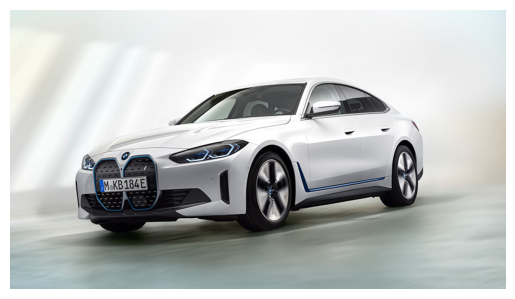

In [9]:
imageurl1 = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"
image_emb1 = image_embedding(imageurl1)

plt.imshow(Image.open(requests.get(imageurl1, stream=True).raw))
plt.axis("off")
plt.show()

## Embedding prompts

In [10]:
text1 = text_embedding("a dog")

In [11]:
get_cosine_similarity(image_emb1, text1)

0.11468548407822445

In [12]:
text2 = text_embedding("a car")

In [13]:
get_cosine_similarity(image_emb1, text2)

0.26817162590374777

## Multiple prompts

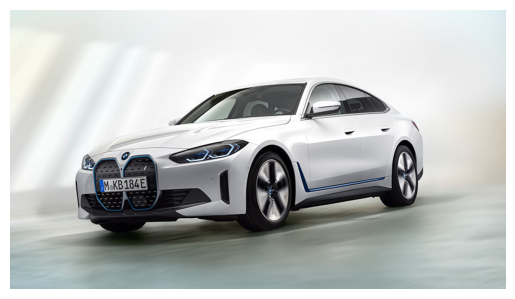

In [14]:
plt.imshow(Image.open(requests.get(imageurl1, stream=True).raw))
plt.axis("off")
plt.show()

In [15]:
prompts = [
    "bird",
    "a truck",
    "a car",
    "a blue car",
    "a white car",
    "a BMW white car",
    "a tesla car",
    "a mercedes car",
    "a man",
    "a ford car",
]

In [16]:
df = similarity_results(image_emb1, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,similarity
0,a BMW white car,0.348607
1,a white car,0.311183
2,a blue car,0.271802
3,a car,0.268172
4,a tesla car,0.226964
5,a ford car,0.225856
6,a mercedes car,0.221614
7,a truck,0.159420
8,a man,0.151208
9,bird,0.136906


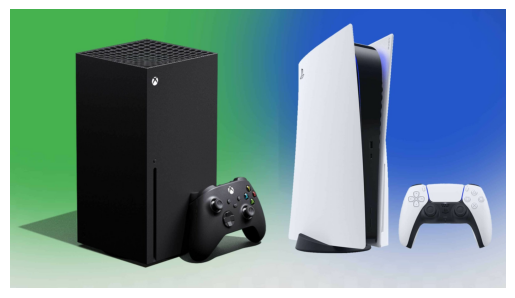

In [17]:
imageurl2 = "https://github.com/retkowsky/images/blob/master/xboxps5.jpg?raw=true"
image_emb2 = image_embedding(imageurl2)

plt.imshow(Image.open(requests.get(imageurl2, stream=True).raw))
plt.axis("off")
plt.show()

In [18]:
prompts = [
    "PS5",
    "Xbox",
    "play station",
    "Sony",
    "controller",
    "Microsoft",
    "games console",
    "guitar",
    "fish",
    "apple",
    "car",
    "street",
    "truck",
    "Miami",
    "black controller",
    "white controller",
]

In [19]:
df = similarity_results(image_emb2, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,similarity
0,Xbox,0.312531
1,games console,0.310375
2,PS5,0.296850
3,white controller,0.275319
4,Microsoft,0.272785
5,controller,0.268243
6,play station,0.263943
7,black controller,0.242207
8,Sony,0.242183
9,truck,0.133874


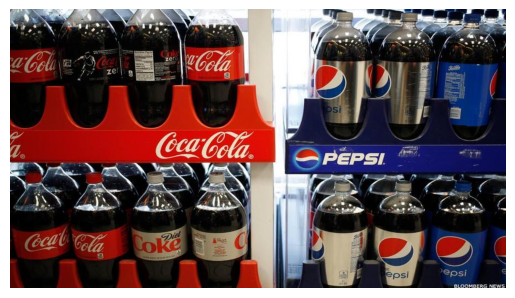

In [20]:
imageurl3 = "https://github.com/retkowsky/images/blob/master/sodas.jpg?raw=true"
image_emb3 = image_embedding(imageurl3)

plt.imshow(Image.open(requests.get(imageurl3, stream=True).raw))
plt.axis("off")
plt.show()

In [21]:
prompts = [
    "a can",
    "coca cola",
    "pepsi",
    "7 up",
    "water",
    "wine",
    "beer",
    "gin",
    "alcohol",
    "lemon",
    "drink",
    "I do not know",
    "food",
    "soda bottles",
    "coke bottle",
]

In [22]:
df = similarity_results(image_emb3, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,similarity
0,soda bottles,0.319888
1,pepsi,0.315002
2,coke bottle,0.288197
3,coca cola,0.285230
4,drink,0.217708
5,alcohol,0.212904
6,7 up,0.203167
7,food,0.171593
8,beer,0.170257
9,a can,0.165751


## Search example using a local image file

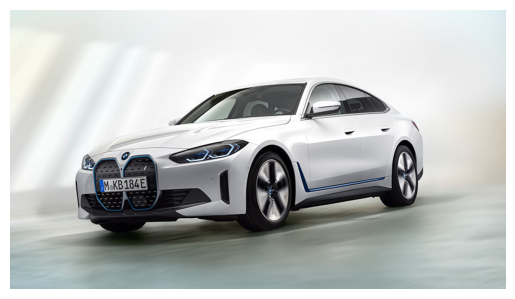

In [23]:
imageurl5 = "https://github.com/retkowsky/images/blob/master/i4.jpg?raw=true"
image_emb5 = image_embedding(imageurl5)

plt.imshow(Image.open(requests.get(imageurl5, stream=True).raw))
plt.axis("off")
plt.show()

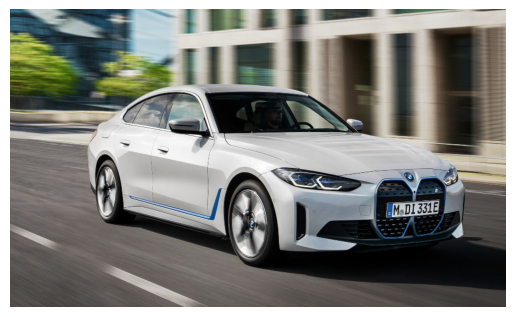

In [24]:
imageurl6 = "https://github.com/retkowsky/images/blob/master/i4_2.jpg?raw=true"
whitebmw = image_embedding(imageurl6)

plt.imshow(Image.open(requests.get(imageurl6, stream=True).raw))
plt.axis("off")
plt.show()

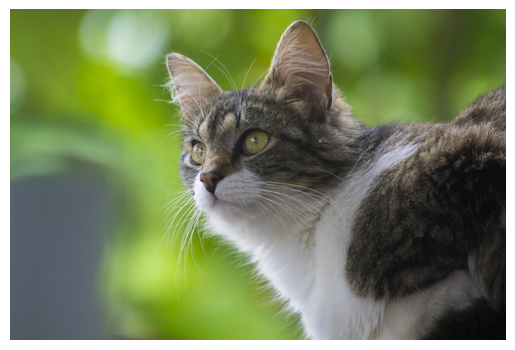

In [25]:
imageurl7 = "https://github.com/retkowsky/images/blob/master/cat.jpg?raw=true"
cat = image_embedding(imageurl7)

plt.imshow(Image.open(requests.get(imageurl7, stream=True).raw))
plt.axis("off")
plt.show()

In [26]:
get_cosine_similarity(image_emb5, image_emb5)

1.0

In [27]:
get_cosine_similarity(image_emb5, whitebmw)

0.947290453455257

In [28]:
get_cosine_similarity(image_emb5, cat)

0.33906303585094566

## Using a local image file (not from an url)

In [29]:
local_image = "images/car.png"

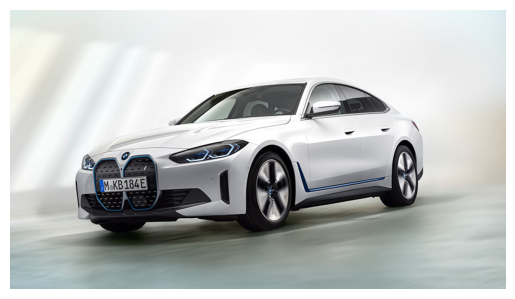

In [30]:
viewimage(filename=local_image)

In [31]:
with open(local_image, "rb") as f:
    data = f.read()

In [32]:
# header to use for local image file
headers_local = {
    "Content-type": "application/octet-stream",
    "Ocp-Apim-Subscription-Key": key,
}

In [33]:
r = requests.post(vec_img_url, data=data, headers=headers_local)
image_emb = r.json()["vector"]

In [36]:
prompts = [
    "bird",
    "a truck",
    "a car",
    "a blue car",
    "a white car",
    "a BMW white car",
    "a tesla car",
    "a mercedes car",
    "a man",
    "a ford car",
    "an i3 bmw",
    "an i4 bmw",
    "a 218 bmw",
]

In [37]:
df = similarity_results(image_emb, prompts)

cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm)

,prompt,similarity
0,an i4 bmw,0.360265
1,a BMW white car,0.355982
2,a white car,0.320126
3,a 218 bmw,0.296017
4,an i3 bmw,0.287901
5,a blue car,0.280411
6,a car,0.269704
7,a tesla car,0.241640
8,a ford car,0.228515
9,a mercedes car,0.224964
